In [39]:
# Import c√°c th∆∞ vi·ªán c·∫ßn thi·∫øt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thi·∫øt l·∫≠p style cho c√°c bi·ªÉu ƒë·ªì
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# X√°c ƒë·ªãnh c√°c lo·∫°i c·ªôt
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']

all_categorical_cols = onehot_cols + categorical_cols
high_card_cols = [col for col in all_categorical_cols if df[col].nunique() > 10]
low_card_cols = [col for col in all_categorical_cols if col not in high_card_cols]

# Category pooling (g·ªôp nh√≥m c√°c gi√° tr·ªã hi·∫øm) - quan tr·ªçng cho Agglomerative Clustering
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# G·ªôp gi√° tr·ªã hi·∫øm cho c√°c c·ªôt c√≥ nhi·ªÅu category
df_processed = df.copy()
for col in high_card_cols:
    df_processed[col] = pool_categories(df_processed[col])

# Frequency Encoding cho c√°c c·ªôt c√≥ nhi·ªÅu category sau khi ƒë√£ g·ªôp
for col in high_card_cols:
    freq_map = df_processed[col].value_counts(normalize=True).to_dict()
    df_processed[col] = df_processed[col].map(freq_map)

# One-hot Encoding cho c√°c c·ªôt c√≥ √≠t category
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
if low_card_cols:
    onehot_encoded = pd.DataFrame(
        onehot_encoder.fit_transform(df_processed[low_card_cols]),
        columns=onehot_encoder.get_feature_names_out(low_card_cols)
    )
    
    # Chu·∫©n h√≥a d·ªØ li·ªáu s·ªë - c·∫ßn thi·∫øt cho Agglomerative Clustering
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # K·∫øt h·ª£p d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω
    df_gmm = pd.concat([
        scaled_numerical,
        onehot_encoded,
        df_processed[high_card_cols]
    ], axis=1)
else:
    # Chu·∫©n h√≥a d·ªØ li·ªáu s·ªë
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # K·∫øt h·ª£p d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω
    df_gmm = pd.concat([
        scaled_numerical,
        df_processed[high_card_cols]
    ], axis=1)

print("\n=== KI·ªÇM TRA D·ªÆ LI·ªÜU SAU KHI TI·ªÄN X·ª¨ L√ù CHO AGGLOMERATIVE CLUSTERING ===")
print("\nD·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a v√† m√£ h√≥a:")
print(df_gmm.head())
print(f"\nK√≠ch th∆∞·ªõc d·ªØ li·ªáu: {df_gmm.shape}")

# L∆∞u d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω
df_gmm.to_csv('../dataset/train_agglomerative_processed.csv', index=False)

df_agg = df_gmm.copy()


=== KI·ªÇM TRA D·ªÆ LI·ªÜU SAU KHI TI·ªÄN X·ª¨ L√ù CHO AGGLOMERATIVE CLUSTERING ===

D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c chu·∫©n h√≥a v√† m√£ h√≥a:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0       -0.962829      -0.767582         -0.281839            0.0   
1       -0.687852      -0.097288         -0.281839            0.0   
2        0.215643       1.075727          0.006708            0.0   
3       -1.316370      -1.437877         -0.397257            0.0   
4       -0.021551       0.237859         -0.281839            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0     

Applying PCA for dimensionality reduction...
Original dimensions: 24
Reduced dimensions with PCA: 12
Explained variance ratio: [0.40216939 0.19892263 0.12517972 0.08898296 0.03644619 0.02388397
 0.02045894 0.01742123 0.01480097 0.01018985 0.00950056 0.00856678]
Total explained variance: 0.9565


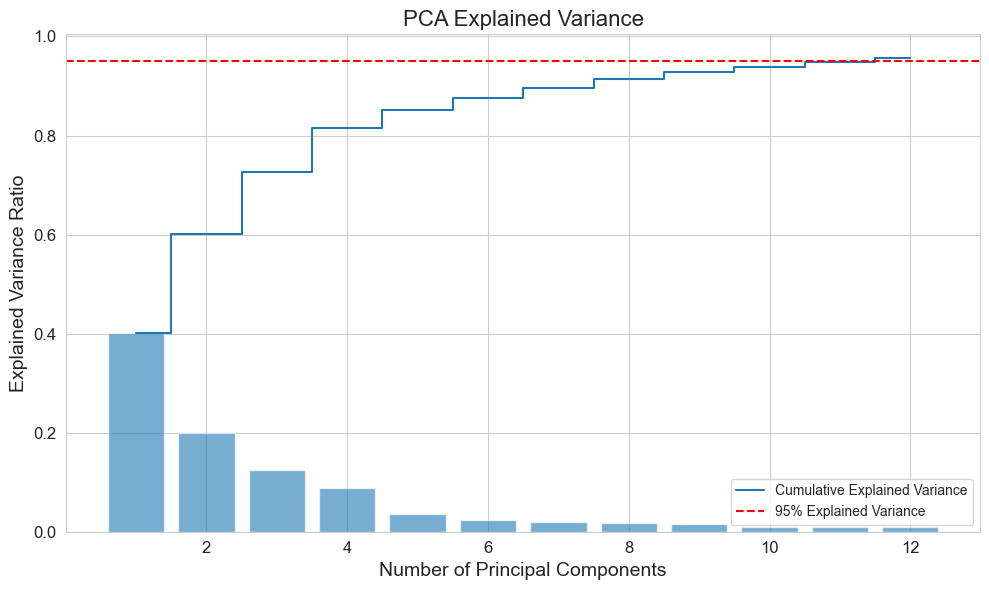

In [41]:
# Apply PCA for dimensionality reduction
# This will help with visualization and improve performance of clustering algorithms
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% of variance
df_pca = pd.DataFrame(pca.fit_transform(df_gmm))

print(f"Original dimensions: {df_gmm.shape[1]}")
print(f"Reduced dimensions with PCA: {df_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
#
# # N·∫øu b·∫°n c√≥ `df_pca` v√† `kproto_clusters`
# plt.figure(figsize=(10, 6))
# plt.scatter(df_pca[0], df_pca[1], c=kproto_clusters, cmap='tab10', alpha=0.7)
# plt.title('PCA Visualization of Clusters (K-Prototypes)')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.colorbar(label='Cluster')
# plt.show()


ƒêang x√°c ƒë·ªãnh s·ªë c·ª•m v√† ki·ªÉu covariance t·ªëi ∆∞u cho GMM...

ƒêang ki·ªÉm tra covariance_type = 'full'
n_components = 2, BIC = 26486.71, AIC = 25284.50
n_components = 3, BIC = -10544.90, AIC = -12351.54
n_components = 4, BIC = -64467.81, AIC = -66878.88
n_components = 5, BIC = -81516.92, AIC = -84532.42
n_components = 6, BIC = -97504.46, AIC = -101124.38
n_components = 7, BIC = -92679.48, AIC = -96903.83



ƒêang ki·ªÉm tra covariance_type = 'tied'
n_components = 2, BIC = 49920.30, AIC = 49236.16
n_components = 3, BIC = 40043.51, AIC = 39273.04
n_components = 4, BIC = 36720.18, AIC = 35863.35
n_components = 5, BIC = 31924.28, AIC = 30981.11
n_components = 6, BIC = 15325.17, AIC = 14295.65
n_components = 7, BIC = 14203.55, AIC = 13087.68


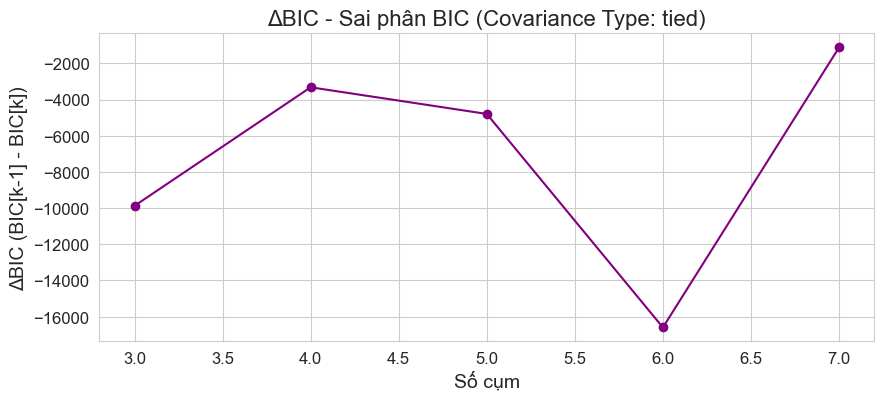


ƒêang ki·ªÉm tra covariance_type = 'diag'
n_components = 2, BIC = 62251.24, AIC = 61925.78
n_components = 3, BIC = 50714.22, AIC = 50222.70
n_components = 4, BIC = 38635.55, AIC = 37977.98
n_components = 5, BIC = 33154.60, AIC = 32330.98
n_components = 6, BIC = 31355.71, AIC = 30366.05
n_components = 7, BIC = 28971.83, AIC = 27816.11


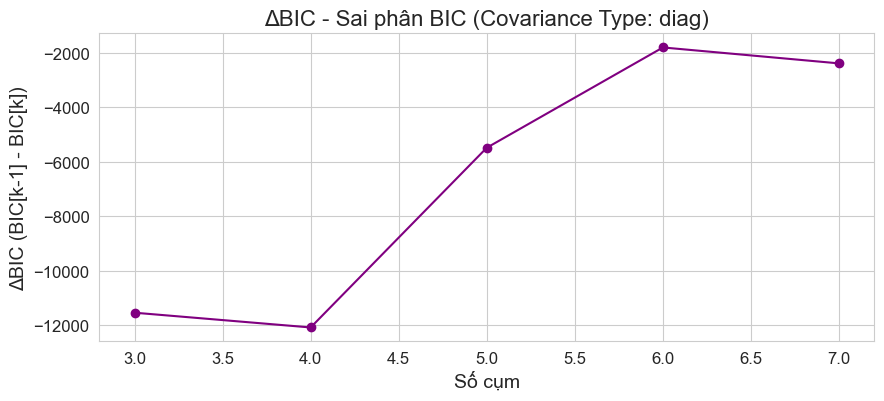


ƒêang ki·ªÉm tra covariance_type = 'spherical'
n_components = 2, BIC = 106662.13, AIC = 106482.80
n_components = 3, BIC = 84351.01, AIC = 84078.68
n_components = 4, BIC = 77841.29, AIC = 77475.98
n_components = 5, BIC = 69801.85, AIC = 69343.55
n_components = 6, BIC = 65224.10, AIC = 64672.81
n_components = 7, BIC = 63095.58, AIC = 62451.30



‚úÖ K·∫øt qu·∫£ t·ªët nh·∫•t theo BIC:
S·ªë c·ª•m t·ªëi ∆∞u: 6
Covariance type t·ªëi ∆∞u: full
Gi√° tr·ªã BIC: -97504.46
Gi√° tr·ªã AIC: -101124.38

üîç T√≠nh Silhouette Score v·ªõi covariance_type = full
n_components = 2, Silhouette Score = 0.1566
n_components = 3, Silhouette Score = 0.1239
n_components = 4, Silhouette Score = 0.0964
n_components = 5, Silhouette Score = 0.1069
n_components = 6, Silhouette Score = 0.0696
n_components = 7, Silhouette Score = 0.0611


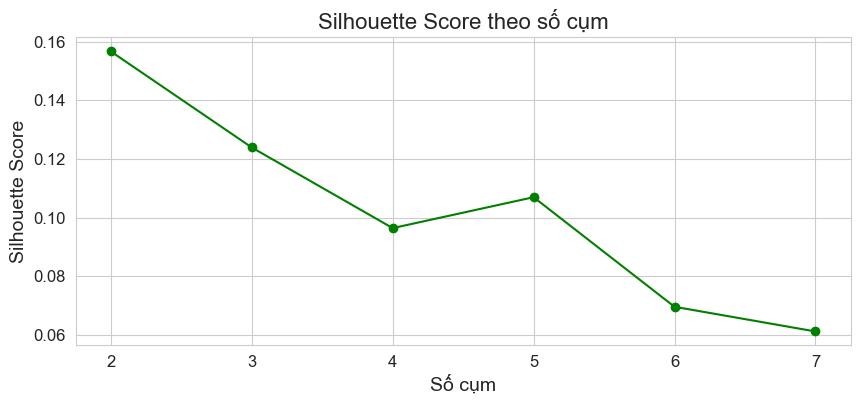


üìâ T√≠nh Davies-Bouldin Index v·ªõi covariance_type = full
n_components = 2, DB Index = 2.3458
n_components = 3, DB Index = 3.0489
n_components = 4, DB Index = 2.9287
n_components = 5, DB Index = 2.5295
n_components = 6, DB Index = 2.5641
n_components = 7, DB Index = 2.9036


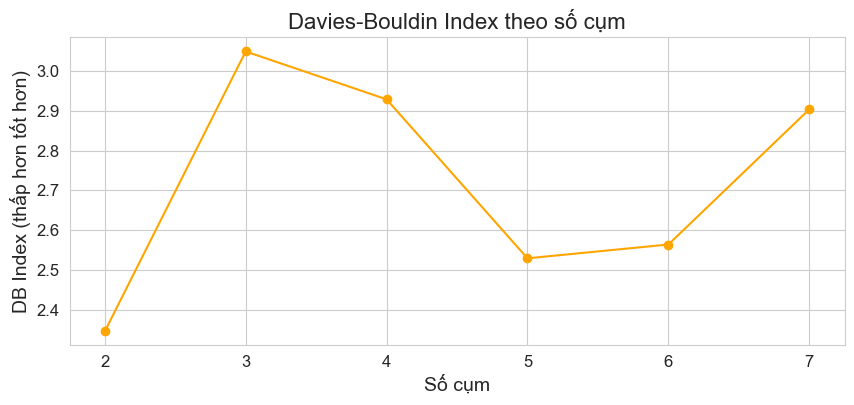

In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

print("ƒêang x√°c ƒë·ªãnh s·ªë c·ª•m v√† ki·ªÉu covariance t·ªëi ∆∞u cho GMM...")

n_components_range = range(2, 8)
covariance_types = ['full', 'tied', 'diag', 'spherical']

results = []

for cov_type in covariance_types:
    bic_scores = []
    aic_scores = []

    print(f"\nƒêang ki·ªÉm tra covariance_type = '{cov_type}'")

    for n_components in n_components_range:
        try:
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=cov_type,
                random_state=42,
                max_iter=100,
                n_init=3
            )
            gmm.fit(df_pca)

            bic = gmm.bic(df_pca)
            aic = gmm.aic(df_pca)

            bic_scores.append(bic)
            aic_scores.append(aic)

            print(f"n_components = {n_components}, BIC = {bic:.2f}, AIC = {aic:.2f}")

            results.append({
                'n_components': n_components,
                'covariance_type': cov_type,
                'bic': bic,
                'aic': aic,
                'model': gmm
            })

        except Exception as e:
            print(f"L·ªói v·ªõi n_components = {n_components}, covariance_type = {cov_type}: {e}")
            bic_scores.append(np.nan)
            aic_scores.append(np.nan)

    # V·∫Ω bi·ªÉu ƒë·ªì BIC/AIC
    plt.figure(figsize=(12, 4))
    plt.plot(n_components_range, bic_scores, label='BIC', marker='o', color='blue')
    plt.plot(n_components_range, aic_scores, label='AIC', marker='x', color='red')
    plt.title(f"Covariance Type: {cov_type}")
    plt.xlabel("S·ªë c·ª•m")
    plt.ylabel("Gi√° tr·ªã (th·∫•p h∆°n t·ªët h∆°n)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # V·∫Ω sai ph√¢n BIC (ŒîBIC)
    delta_bic = np.diff(bic_scores)
    plt.figure(figsize=(10, 4))
    plt.plot(n_components_range[1:], delta_bic, marker='o', linestyle='-', color='purple')
    plt.title(f"ŒîBIC - Sai ph√¢n BIC (Covariance Type: {cov_type})")
    plt.xlabel("S·ªë c·ª•m")
    plt.ylabel("ŒîBIC (BIC[k-1] - BIC[k])")
    plt.grid(True)
    plt.show()

# Ch·ªçn m√¥ h√¨nh c√≥ BIC t·ªët nh·∫•t
best_result = min(results, key=lambda x: x['bic'])

print("\n‚úÖ K·∫øt qu·∫£ t·ªët nh·∫•t theo BIC:")
print(f"S·ªë c·ª•m t·ªëi ∆∞u: {best_result['n_components']}")
print(f"Covariance type t·ªëi ∆∞u: {best_result['covariance_type']}")
print(f"Gi√° tr·ªã BIC: {best_result['bic']:.2f}")
print(f"Gi√° tr·ªã AIC: {best_result['aic']:.2f}")

# GMM t·ªët nh·∫•t
best_cov_type = best_result['covariance_type']
best_gmm = best_result['model']

# --- Silhouette Score ---
print("\nüîç T√≠nh Silhouette Score v·ªõi covariance_type =", best_cov_type)
sil_scores = []

for n_components in n_components_range:
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type=best_cov_type, random_state=42)
        gmm.fit(df_pca)
        labels = gmm.predict(df_pca)
        sil = silhouette_score(df_pca, labels)
        sil_scores.append(sil)
        print(f"n_components = {n_components}, Silhouette Score = {sil:.4f}")
    except:
        sil_scores.append(np.nan)

plt.figure(figsize=(10, 4))
plt.plot(n_components_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Score theo s·ªë c·ª•m")
plt.xlabel("S·ªë c·ª•m")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# --- Davies-Bouldin Index ---
print("\nüìâ T√≠nh Davies-Bouldin Index v·ªõi covariance_type =", best_cov_type)
db_scores = []

for n_components in n_components_range:
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type=best_cov_type, random_state=42)
        gmm.fit(df_pca)
        labels = gmm.predict(df_pca)
        db = davies_bouldin_score(df_pca, labels)
        db_scores.append(db)
        print(f"n_components = {n_components}, DB Index = {db:.4f}")
    except:
        db_scores.append(np.nan)

plt.figure(figsize=(10, 4))
plt.plot(n_components_range, db_scores, marker='o', color='orange')
plt.title("Davies-Bouldin Index theo s·ªë c·ª•m")
plt.xlabel("S·ªë c·ª•m")
plt.ylabel("DB Index (th·∫•p h∆°n t·ªët h∆°n)")
plt.grid(True)
plt.show()

# G√°n nh√£n c·ª•m v√†o df_original ƒë·ªÉ ph·ª•c v·ª• tr·ª±c quan h√≥a ph√≠a sau
df_original['gmm_cluster'] = best_gmm.predict(df_pca)

# 5. Tr·ª±c quan h√≥a k·∫øt qu·∫£ ph√¢n c·ª•m GMM

Ch√∫ng ta s·∫Ω gi·∫£m chi·ªÅu d·ªØ li·ªáu xu·ªëng 2 th√†nh ph·∫ßn ch√≠nh b·∫±ng PCA v√† tr·ª±c quan h√≥a c√°c c·ª•m GMM tr√™n kh√¥ng gian n√†y ƒë·ªÉ so s√°nh v·ªõi Agglomerative Clustering.

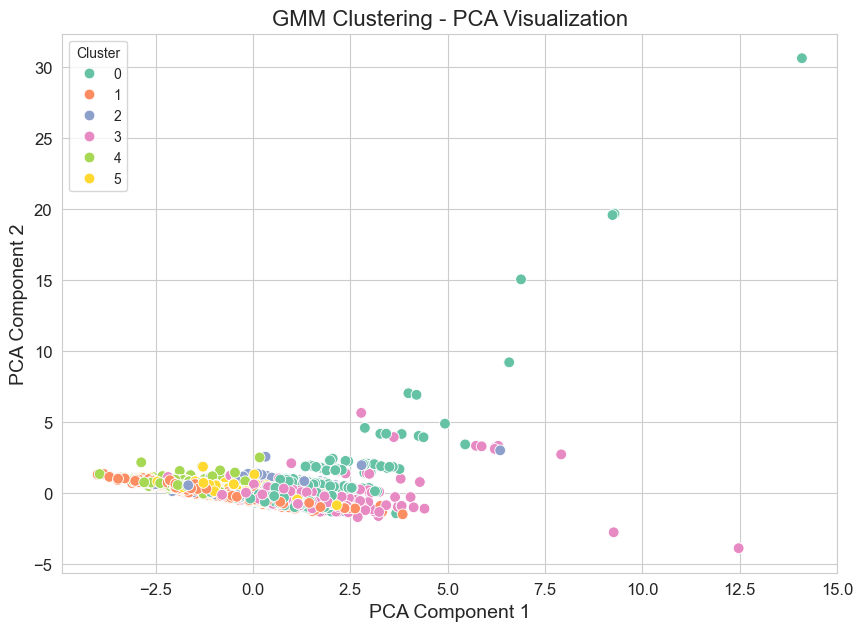

Ph∆∞∆°ng sai gi·∫£i th√≠ch b·ªüi 2 th√†nh ph·∫ßn ch√≠nh: 60.11%
PCA1: 40.22%, PCA2: 19.89%


In [43]:
# Gi·∫£m chi·ªÅu d·ªØ li·ªáu xu·ªëng 2 th√†nh ph·∫ßn ch√≠nh ƒë·ªÉ tr·ª±c quan h√≥a
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
pca_2d = pca_vis.fit_transform(df_gmm)
df_original['pca_1'] = pca_2d[:, 0]
df_original['pca_2'] = pca_2d[:, 1]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_original, x='pca_1', y='pca_2', hue='gmm_cluster', palette='Set2', s=60)
plt.title('GMM Clustering - PCA Visualization', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

explained_var = pca_vis.explained_variance_ratio_
print(f"Ph∆∞∆°ng sai gi·∫£i th√≠ch b·ªüi 2 th√†nh ph·∫ßn ch√≠nh: {sum(explained_var)*100:.2f}%")
print(f"PCA1: {explained_var[0]*100:.2f}%, PCA2: {explained_var[1]*100:.2f}%")

## 6. Ph√¢n t√≠ch ƒë·∫∑c ƒëi·ªÉm c·ªßa c√°c c·ª•m GMM

### 6.1. Ph√¢n t√≠ch ƒë·∫∑c tr∆∞ng s·ªë

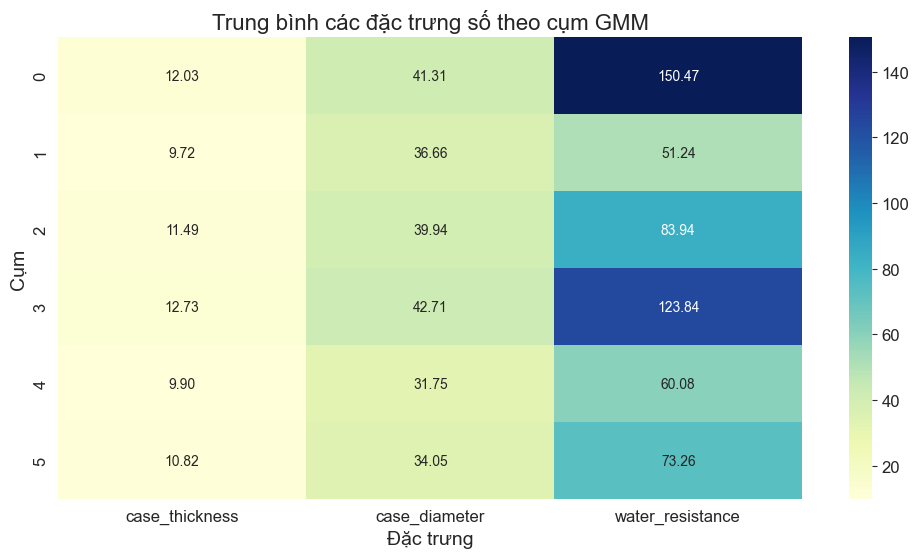

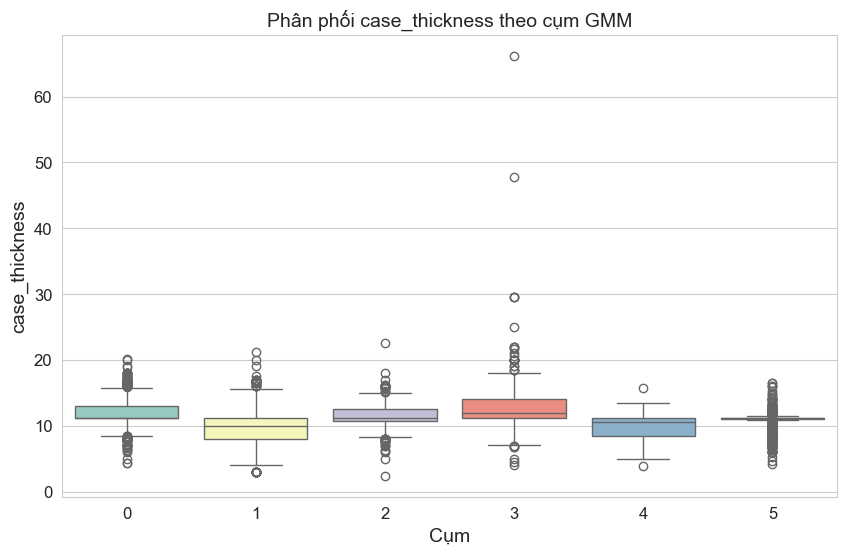

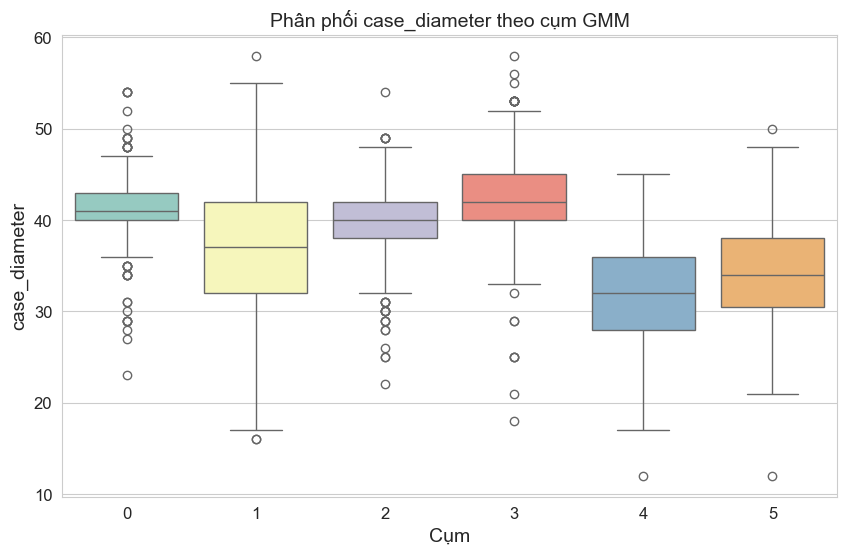

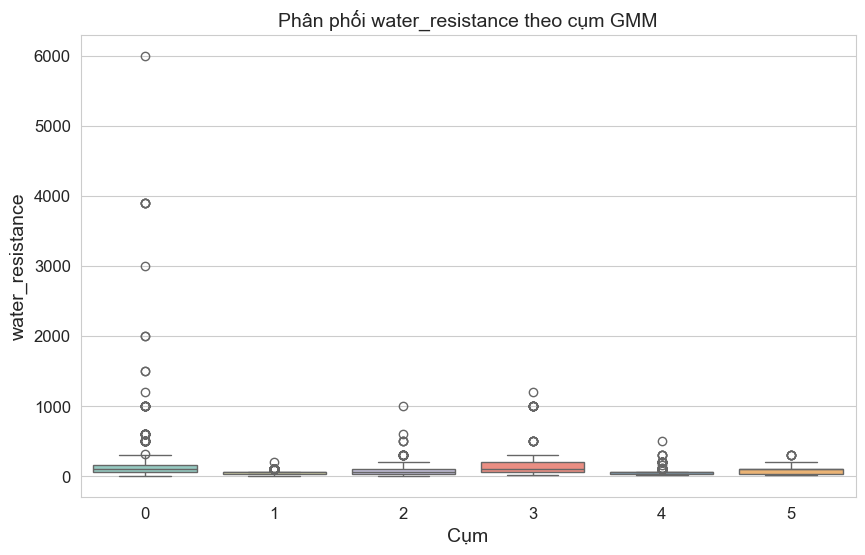

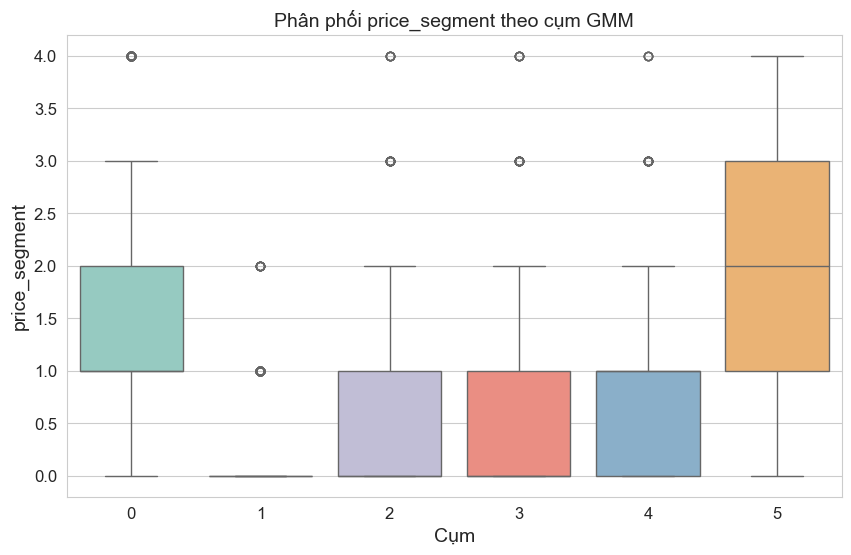

In [44]:
# Trung b√¨nh c√°c ƒë·∫∑c tr∆∞ng s·ªë theo c·ª•m GMM
num_cols = ['case_thickness', 'case_diameter', 'water_resistance']
cluster_means = df_original.groupby('gmm_cluster')[num_cols].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Trung b√¨nh c√°c ƒë·∫∑c tr∆∞ng s·ªë theo c·ª•m GMM', fontsize=16)
plt.ylabel('C·ª•m')
plt.xlabel('ƒê·∫∑c tr∆∞ng')
plt.show()

# Boxplot cho t·ª´ng ƒë·∫∑c tr∆∞ng s·ªë v√† price_segment theo c·ª•m
for col in num_cols + ['price_segment']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_original, x='gmm_cluster', y=col, palette='Set3')
    plt.title(f'Ph√¢n ph·ªëi {col} theo c·ª•m GMM', fontsize=14)
    plt.xlabel('C·ª•m')
    plt.ylabel(col)
    plt.show()

### 6.2. Ph√¢n t√≠ch ƒë·∫∑c tr∆∞ng ph√¢n lo·∫°i theo c·ª•m GMM

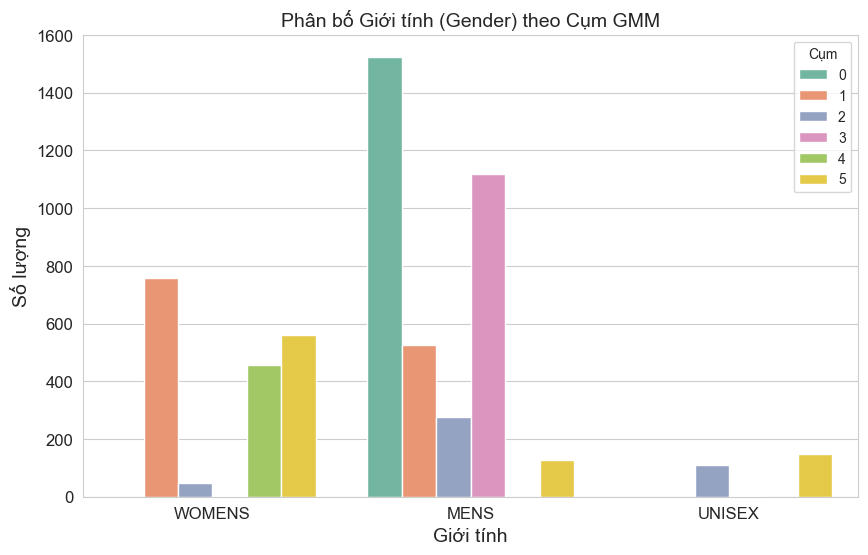

<Figure size 1000x600 with 0 Axes>

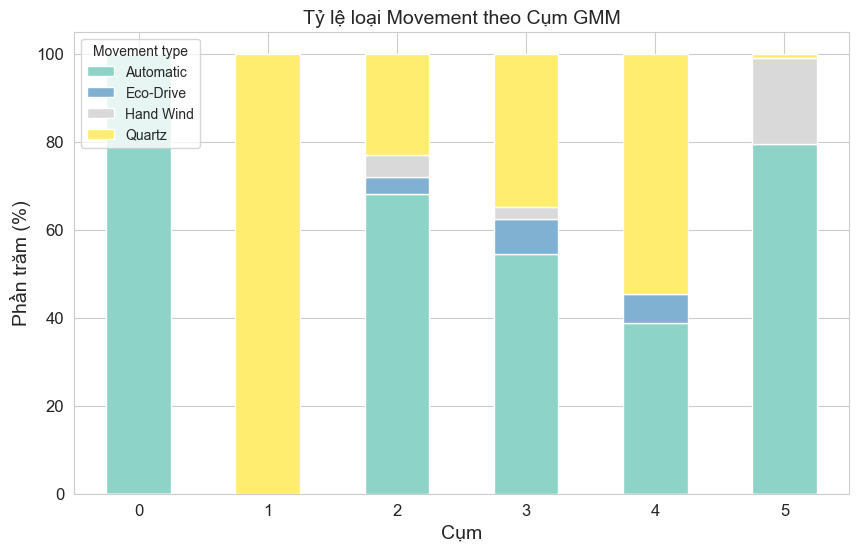

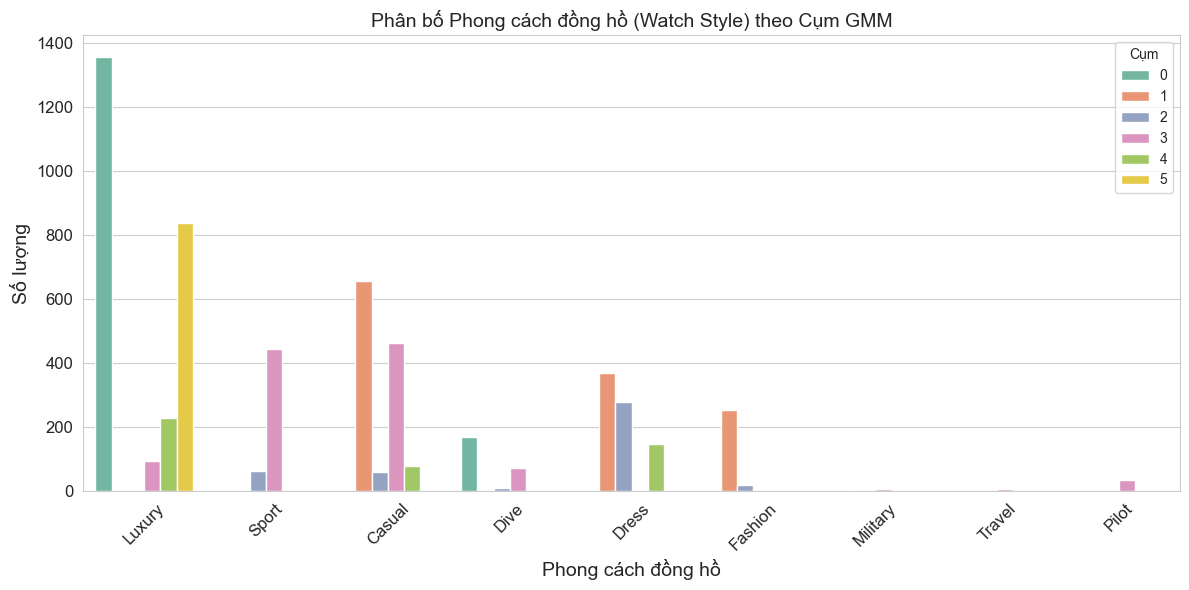

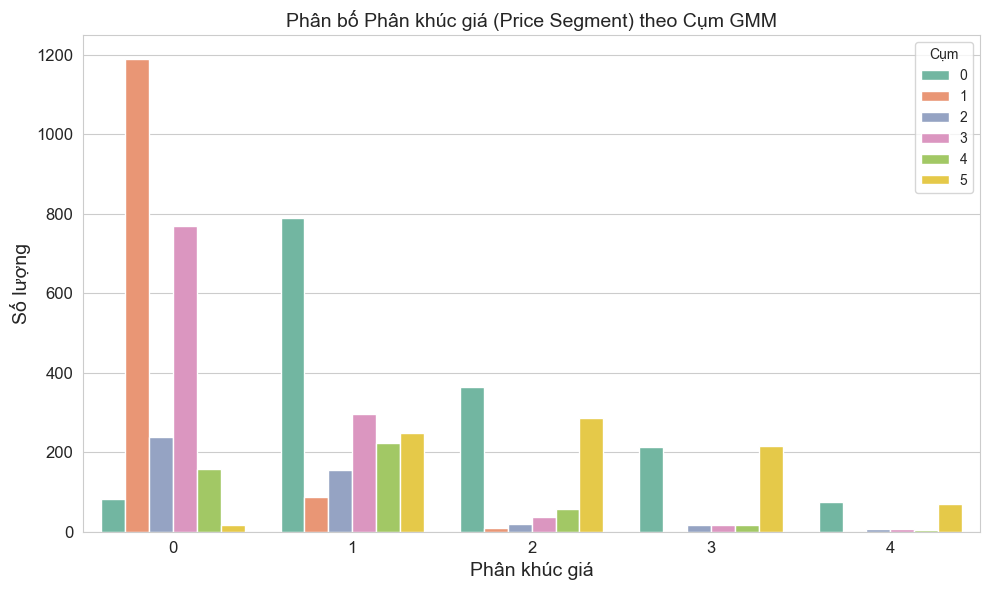

In [45]:
# Gender distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Ph√¢n b·ªë Gi·ªõi t√≠nh (Gender) theo C·ª•m GMM', fontsize=14)
plt.xlabel('Gi·ªõi t√≠nh')
plt.ylabel('S·ªë l∆∞·ª£ng')
plt.legend(title='C·ª•m')
plt.show()

# Movement type distribution by cluster
plt.figure(figsize=(10, 6))
movement_counts = df_original.groupby(['gmm_cluster', 'movement']).size().unstack()
movement_proportions = movement_counts.div(movement_counts.sum(axis=1), axis=0) * 100
movement_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('T·ª∑ l·ªá lo·∫°i Movement theo C·ª•m GMM', fontsize=14)
plt.xlabel('C·ª•m')
plt.ylabel('Ph·∫ßn trƒÉm (%)')
plt.legend(title='Movement type')
plt.xticks(rotation=0)
plt.show()

# Watch style distribution by cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='watch_style', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Ph√¢n b·ªë Phong c√°ch ƒë·ªìng h·ªì (Watch Style) theo C·ª•m GMM', fontsize=14)
plt.xlabel('Phong c√°ch ƒë·ªìng h·ªì')
plt.ylabel('S·ªë l∆∞·ª£ng')
plt.legend(title='C·ª•m')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# price_segment distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='price_segment', hue='gmm_cluster', data=df_original, palette='Set2')
plt.title('Ph√¢n b·ªë Ph√¢n kh√∫c gi√° (Price Segment) theo C·ª•m GMM', fontsize=14)
plt.xlabel('Ph√¢n kh√∫c gi√°')
plt.ylabel('S·ªë l∆∞·ª£ng')
plt.legend(title='C·ª•m')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

T·ª∑ l·ªá price_segment trong m·ªói c·ª•m GMM (%):
price_segment     0     1     2     3    4
gmm_cluster                               
0               5.4  51.7  23.9  14.0  4.9
1              92.5   6.8   0.7   0.0  0.0
2              54.8  35.3   4.6   3.9  1.4
3              68.6  26.3   3.2   1.4  0.5
4              34.6  48.6  12.3   3.7  0.9
5               2.1  29.7  34.2  25.7  8.2


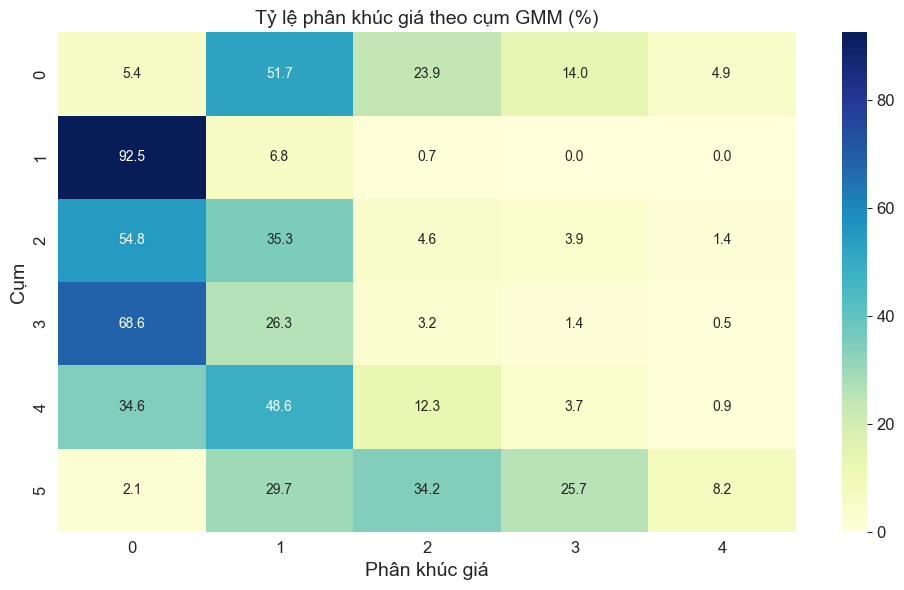

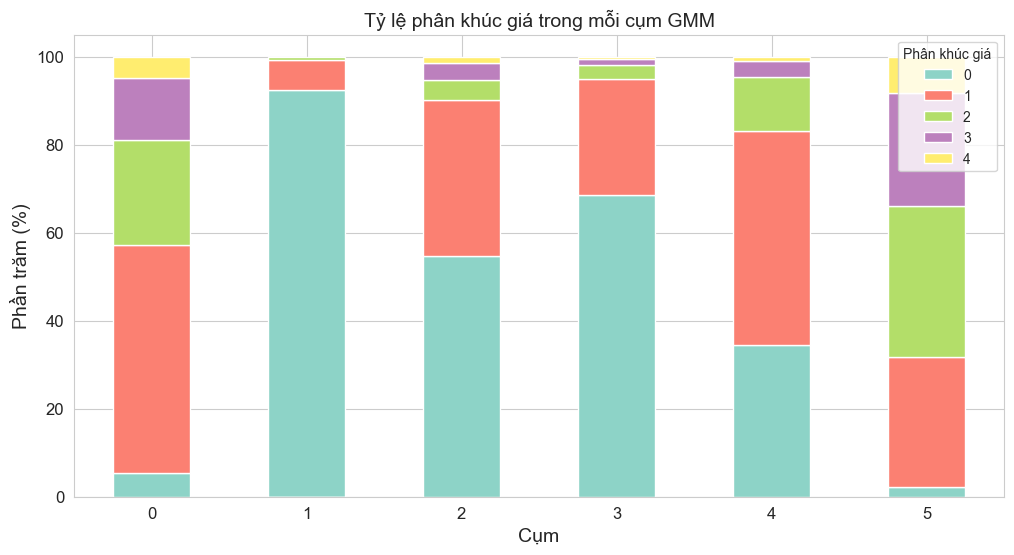

In [46]:
# T·∫°o b·∫£ng t·ª∑ l·ªá price_segment trong m·ªói c·ª•m GMM
segment_cluster_df = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'], normalize='index') * 100
segment_cluster_df = segment_cluster_df.round(1)

print("T·ª∑ l·ªá price_segment trong m·ªói c·ª•m GMM (%):")
print(segment_cluster_df)

plt.figure(figsize=(10, 6))
sns.heatmap(segment_cluster_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('T·ª∑ l·ªá ph√¢n kh√∫c gi√° theo c·ª•m GMM (%)', fontsize=14)
plt.xlabel('Ph√¢n kh√∫c gi√°')
plt.ylabel('C·ª•m')
plt.tight_layout()
plt.show()

# Stacked bar chart cho price_segment theo c·ª•m GMM
segment_counts = df_original.groupby(['gmm_cluster', 'price_segment']).size().unstack()
segment_proportions = segment_counts.div(segment_counts.sum(axis=1), axis=0) * 100
segment_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('T·ª∑ l·ªá ph√¢n kh√∫c gi√° trong m·ªói c·ª•m GMM', fontsize=14)
plt.xlabel('C·ª•m')
plt.ylabel('Ph·∫ßn trƒÉm (%)')
plt.legend(title='Ph√¢n kh√∫c gi√°')
plt.xticks(rotation=0)
plt.show()

In [47]:
# Ki·ªÉm ƒë·ªãnh chi-square gi·ªØa c·ª•m GMM v√† price_segment
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_original['gmm_cluster'], df_original['price_segment'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("K·∫øt lu·∫≠n: C√≥ m·ªëi li√™n h·ªá c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa c·ª•m v√† ph√¢n kh√∫c gi√°" if p < 0.05 else "K·∫øt lu·∫≠n: Kh√¥ng c√≥ m·ªëi li√™n h·ªá c√≥ √Ω nghƒ©a th·ªëng k√™")

Chi-square statistic: 3616.28
p-value: 0.0000
Degrees of freedom: 20
K·∫øt lu·∫≠n: C√≥ m·ªëi li√™n h·ªá c√≥ √Ω nghƒ©a th·ªëng k√™ gi·ªØa c·ª•m v√† ph√¢n kh√∫c gi√°


### 6.3. Ph√¢n t√≠ch th∆∞∆°ng hi·ªáu (Brand) theo c·ª•m GMM

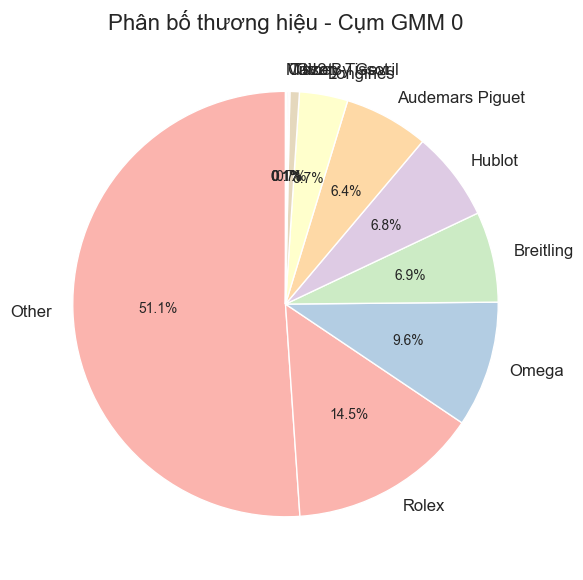

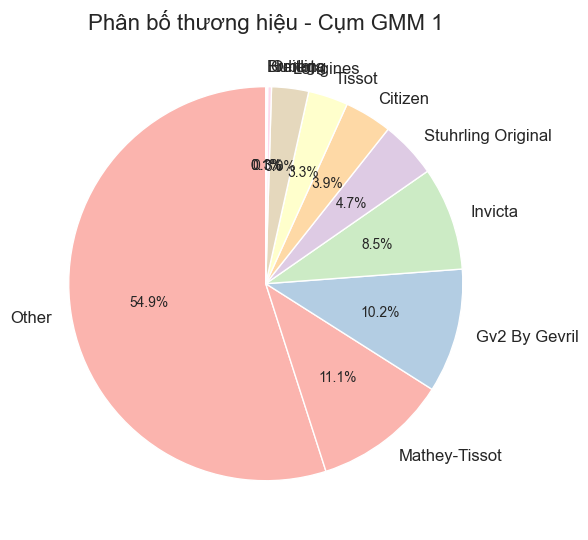

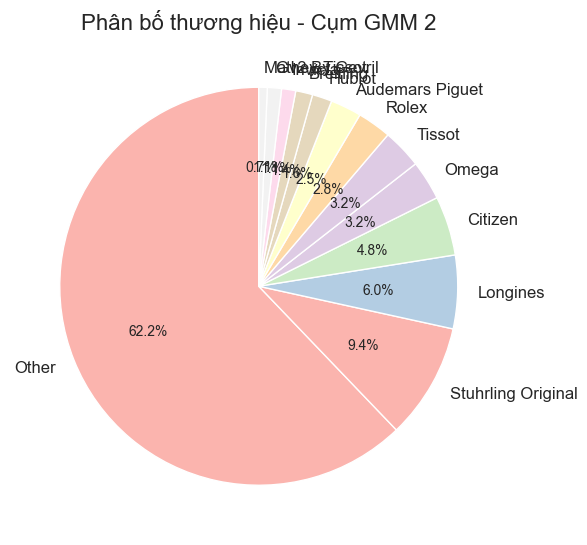

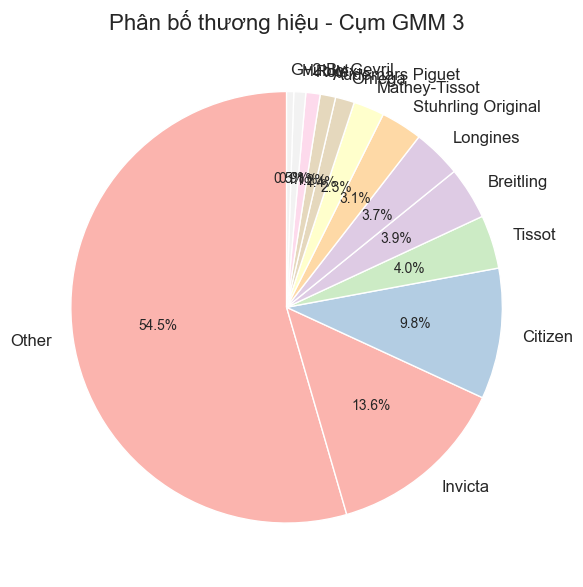

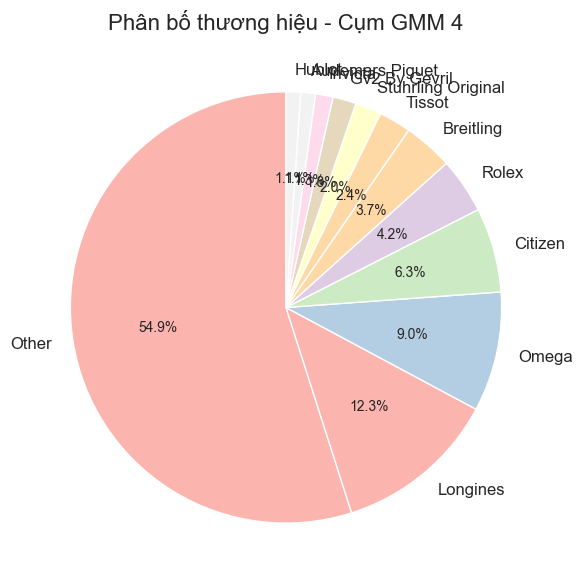

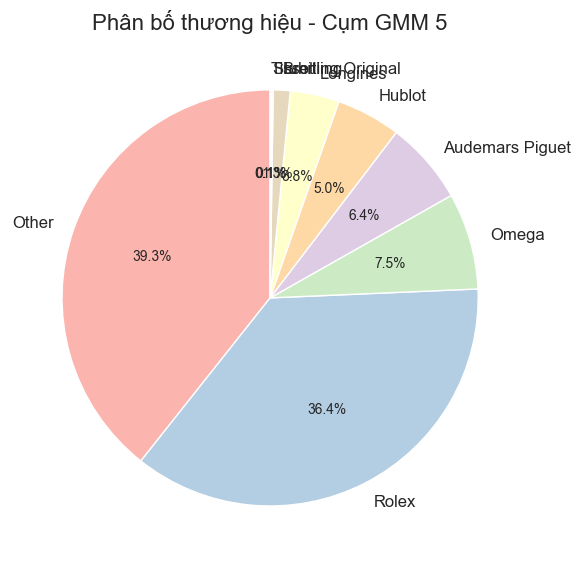

In [48]:
# G·ªôp th∆∞∆°ng hi·ªáu hi·∫øm th√†nh 'Other'
def pool_categories(series, threshold=0.02):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

df_original['brand_pooled'] = pool_categories(df_original['brand'], threshold=0.02)

for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    plt.figure(figsize=(6, 6))
    brand_counts = df_original[df_original['gmm_cluster'] == cluster_id]['brand_pooled'].value_counts()
    brand_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
    plt.title(f"Ph√¢n b·ªë th∆∞∆°ng hi·ªáu - C·ª•m GMM {cluster_id}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

## 7. Ph√¢n t√≠ch ƒëa chi·ªÅu (Multivariate Analysis) cho GMM

Bi·ªÉu ƒë·ªì t·ªça ƒë·ªô song song gi√∫p so s√°nh c√°c ƒë·∫∑c tr∆∞ng s·ªë v√† price_segment gi·ªØa c√°c c·ª•m GMM.

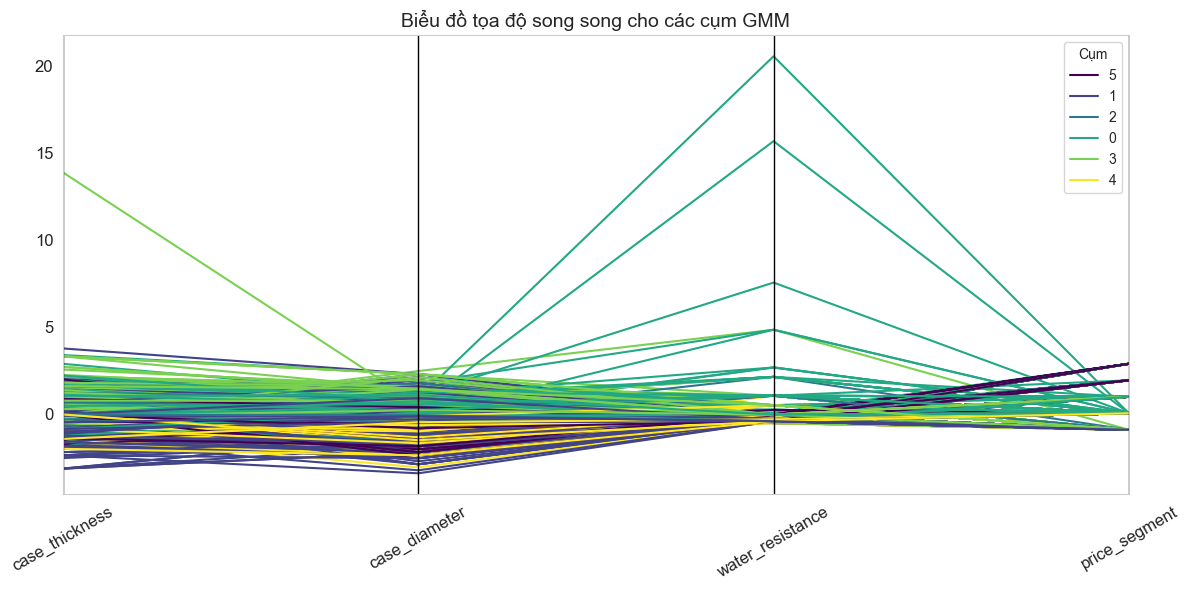

In [49]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

parallel_features = num_cols + ['price_segment']
sample_size = min(1000, len(df_original))
df_sample = df_original.sample(sample_size, random_state=42) if len(df_original) > sample_size else df_original
parallel_df = df_sample[parallel_features + ['gmm_cluster']].copy()
scaler = StandardScaler()
parallel_df[parallel_features] = scaler.fit_transform(parallel_df[parallel_features])

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_df, 'gmm_cluster', colormap='viridis')
plt.title('Bi·ªÉu ƒë·ªì t·ªça ƒë·ªô song song cho c√°c c·ª•m GMM', fontsize=14)
plt.grid(False)
plt.legend(title='C·ª•m')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Ph√¢n t√≠ch m·ªëi quan h·ªá gi·ªØa c√°c ƒë·∫∑c tr∆∞ng s·ªë theo c·ª•m GMM

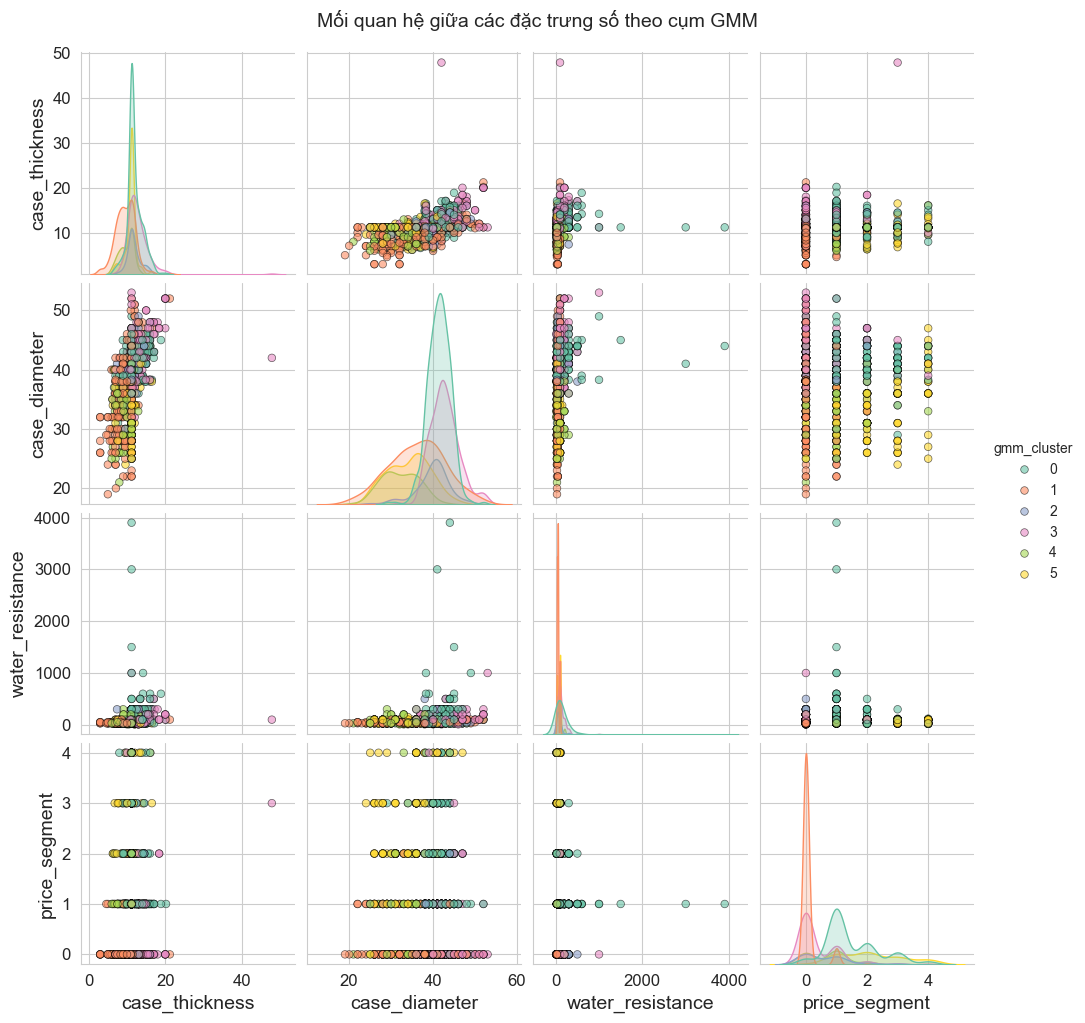

In [50]:
sns.pairplot(df_sample, vars=num_cols + ['price_segment'], hue='gmm_cluster', palette='Set2', 
             height=2.5, plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('M·ªëi quan h·ªá gi·ªØa c√°c ƒë·∫∑c tr∆∞ng s·ªë theo c·ª•m GMM', y=1.02, fontsize=14)
plt.show()

## 9. ƒê·∫∑c ƒëi·ªÉm v√† ph√¢n lo·∫°i c√°c c·ª•m GMM

D·ª±a tr√™n c√°c ph√¢n t√≠ch tr√™n, b·∫°n c√≥ th·ªÉ m√¥ t·∫£ ƒë·∫∑c ƒëi·ªÉm t·ª´ng c·ª•m GMM t∆∞∆°ng t·ª± nh∆∞ ph·∫ßn Agglomerative Clustering ƒë·ªÉ so s√°nh.

T√≥m t·∫Øt c√°c c·ª•m GMM:
   gmm_cluster  sample_count  percentage
0            0          1525   26.919682
1            1          1285   22.683142
2            3          1123   19.823477
3            5           839   14.810238
4            4           457    8.067079
5            2           436    7.696381


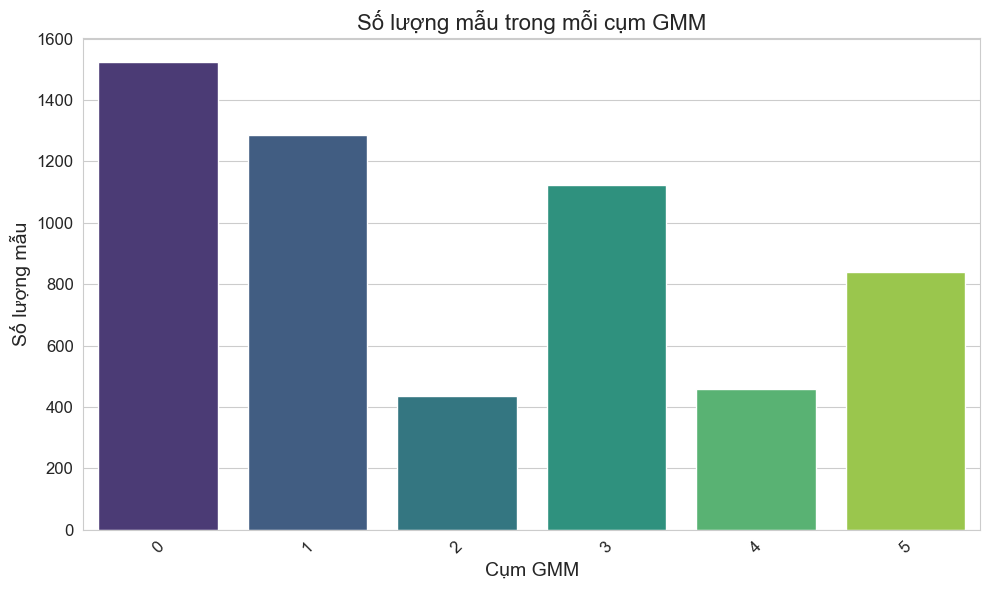


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 0:
       case_thickness  case_diameter  water_resistance  price_segment
count     1525.000000    1525.000000       1525.000000    1525.000000
mean        12.028801      41.307460        150.474668       1.613770
std          1.942077       2.833357        301.251986       0.959656
min          4.300000      23.000000          3.000000       0.000000
25%         11.196182      40.000000         50.000000       1.000000
50%         11.196182      41.000000        100.000000       1.000000
75%         13.000000      43.000000        150.000000       2.000000
max         20.200000      54.000000       6000.000000       4.000000


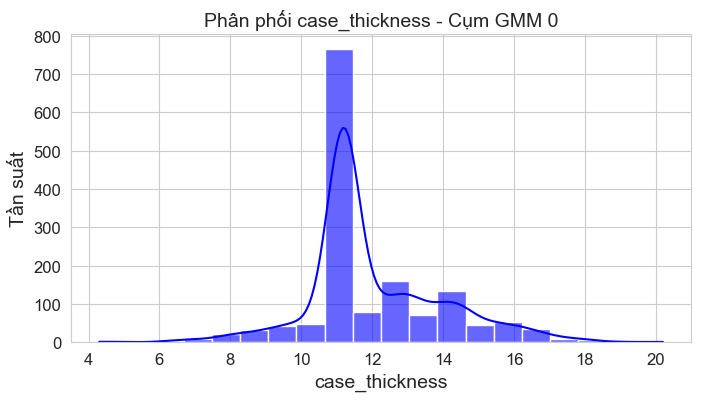

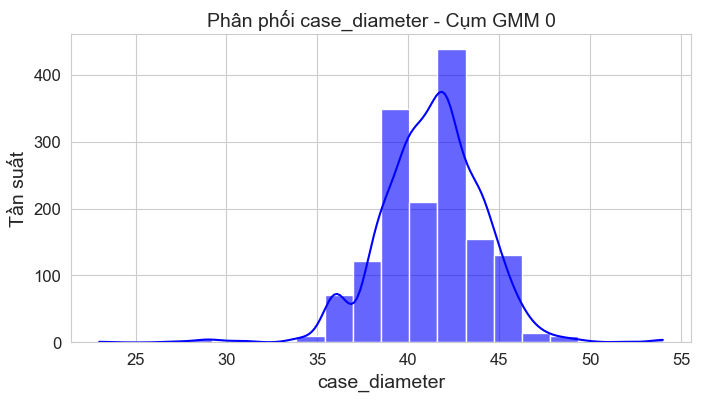

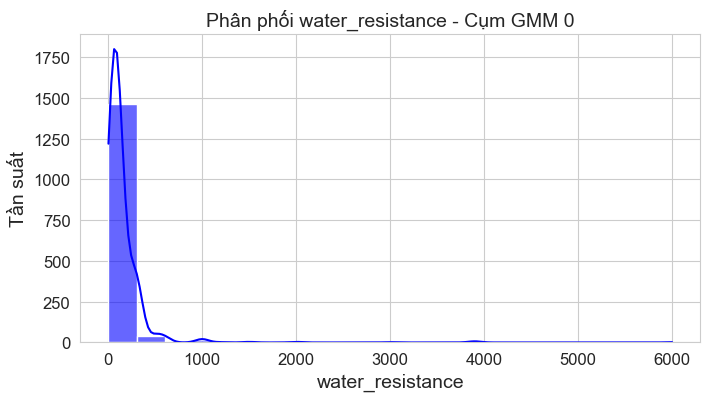


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 1:
       case_thickness  case_diameter  water_resistance  price_segment
count     1285.000000    1285.000000       1285.000000    1285.000000
mean         9.722089      36.662791         51.240979       0.081712
std          2.450922       6.670246         25.378763       0.298517
min          3.000000      16.000000          3.000000       0.000000
25%          8.000000      32.000000         30.000000       0.000000
50%         10.000000      37.000000         50.000000       0.000000
75%         11.196182      42.000000         50.000000       0.000000
max         21.200000      58.000000        200.000000       2.000000


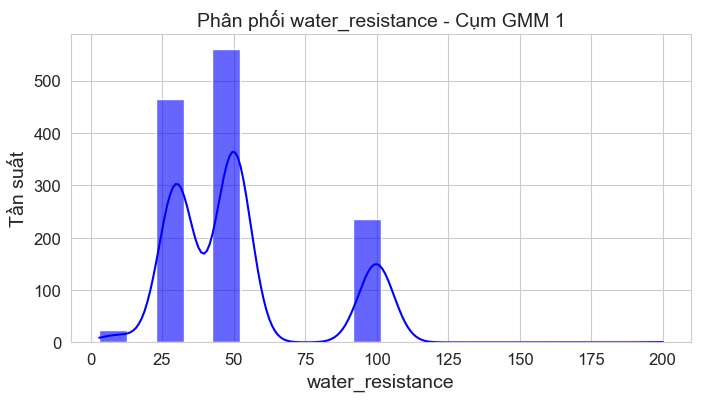


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 2:
       case_thickness  case_diameter  water_resistance  price_segment
count      436.000000     436.000000        436.000000     436.000000
mean        11.486402      39.938291         83.937424       0.616972
std          2.011053       4.115456         87.468190       0.853706
min          2.400000      22.000000          3.000000       0.000000
25%         10.770000      38.000000         30.000000       0.000000
50%         11.196182      40.000000         50.000000       0.000000
75%         12.500000      42.000000        100.000000       1.000000
max         22.500000      54.000000       1000.000000       4.000000


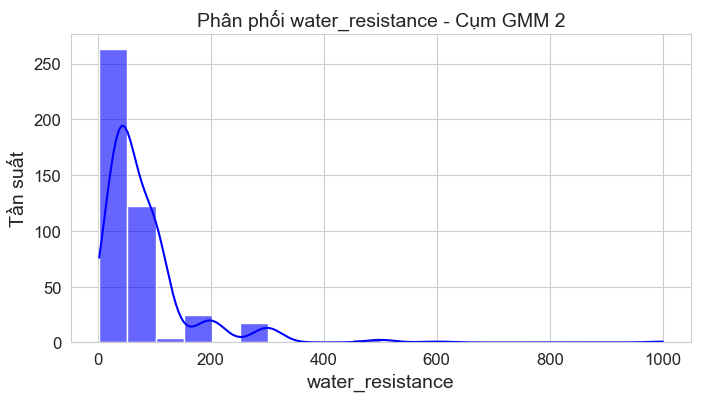


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 3:
       case_thickness  case_diameter  water_resistance  price_segment
count     1123.000000    1123.000000       1123.000000    1123.000000
mean        12.726228      42.708621        123.840301       0.390917
std          3.146999       3.711303        119.862182       0.672471
min          4.000000      18.000000         10.000000       0.000000
25%         11.196182      40.000000         50.000000       0.000000
50%         12.000000      42.000000        100.000000       0.000000
75%         14.000000      45.000000        200.000000       1.000000
max         66.200000      58.000000       1200.000000       4.000000


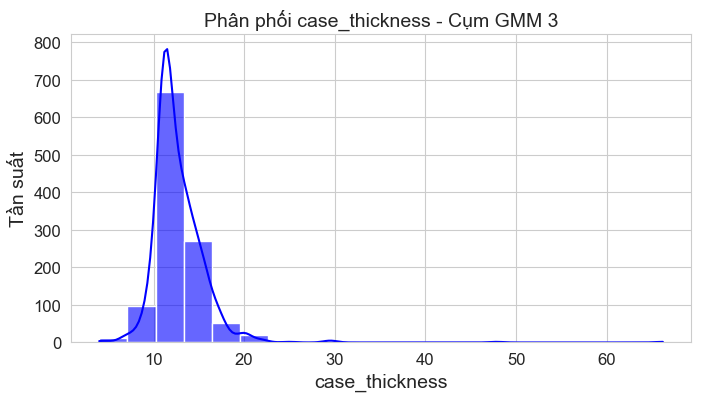

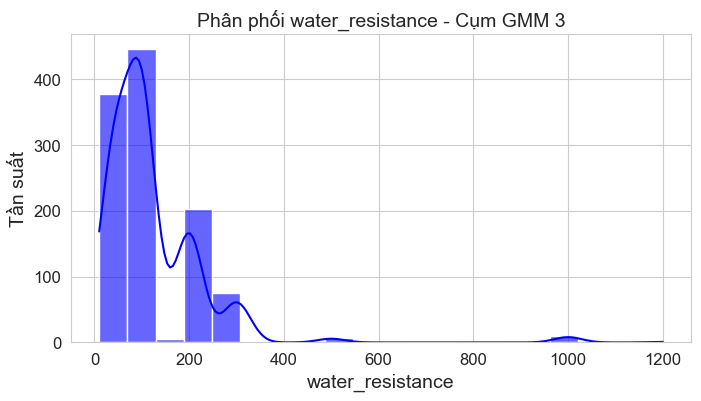


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 4:
       case_thickness  case_diameter  water_resistance  price_segment
count      457.000000     457.000000        457.000000     457.000000
mean         9.903460      31.751633         60.083741       0.877462
std          1.736096       4.791077         50.441141       0.826027
min          3.900000      12.000000         10.000000       0.000000
25%          8.500000      28.000000         30.000000       0.000000
50%         10.500000      32.000000         50.000000       1.000000
75%         11.196182      36.000000         50.000000       1.000000
max         15.800000      45.000000        500.000000       4.000000


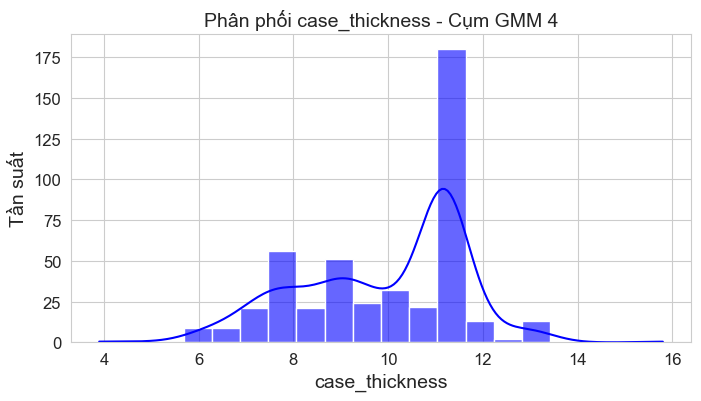

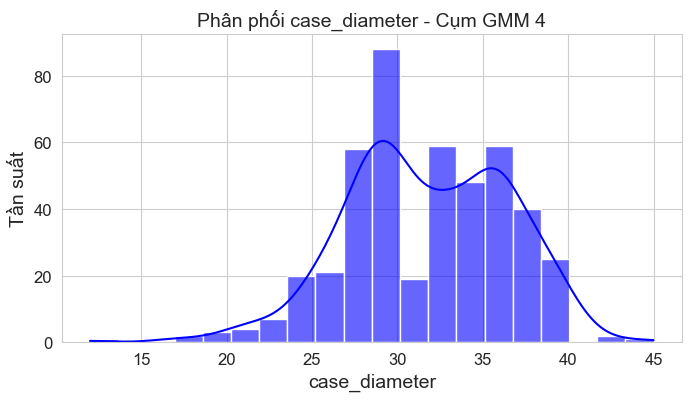

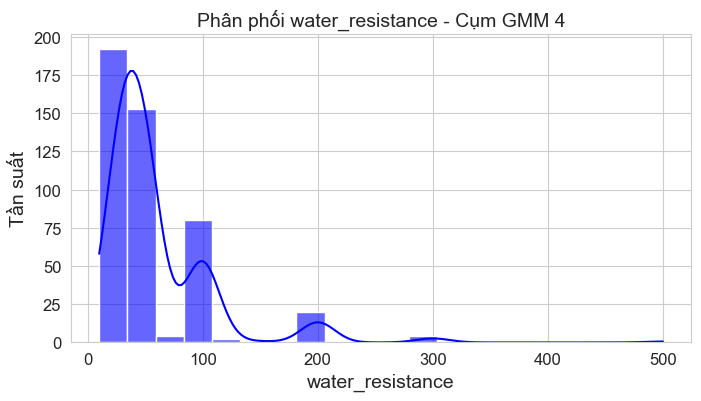


ƒê·∫∑c ƒëi·ªÉm c·ª•m GMM 5:
       case_thickness  case_diameter  water_resistance  price_segment
count      839.000000     839.000000        839.000000     839.000000
mean        10.816274      34.050051         73.264836       2.082241
std          1.391327       5.412323         40.109926       0.981527
min          4.130000      12.000000         20.000000       0.000000
25%         11.050000      30.500000         30.000000       1.000000
50%         11.196182      34.000000        100.000000       2.000000
75%         11.196182      38.000000        100.000000       3.000000
max         16.500000      50.000000        300.000000       4.000000


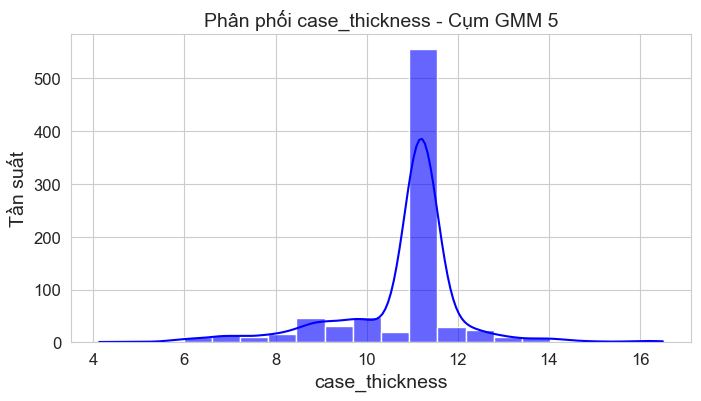

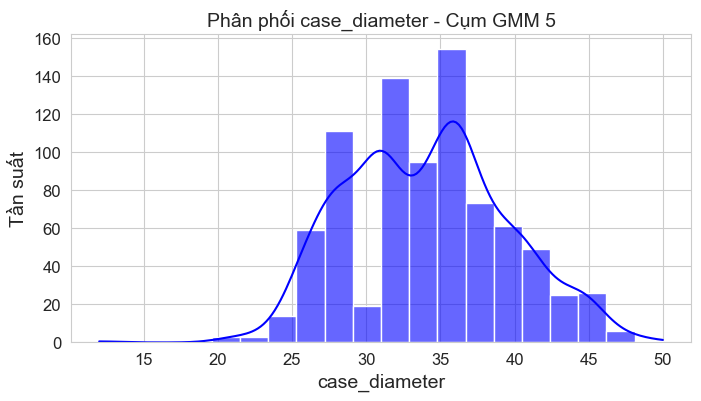

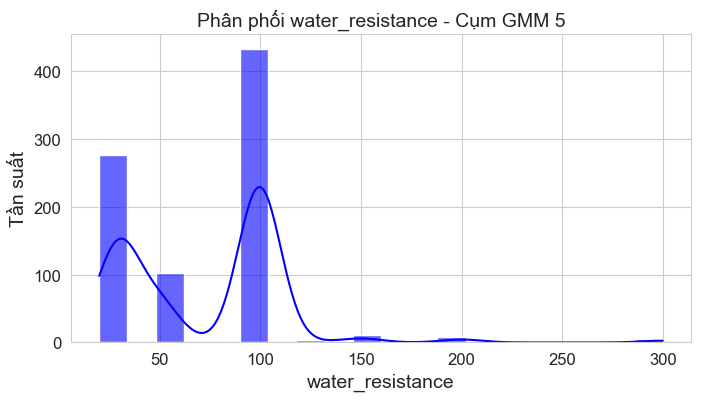

In [51]:
# Xu·∫•t danh s√°ch c√°c c·ª•m GMM v√† s·ªë l∆∞·ª£ng m·∫´u trong m·ªói c·ª•m
gmm_cluster_counts = df_original['gmm_cluster'].value_counts().reset_index()
gmm_cluster_counts.columns = ['gmm_cluster', 'sample_count']

# T√≠nh to√°n t·ª∑ l·ªá ph·∫ßn trƒÉm cho m·ªói c·ª•m
total_samples = len(df_original)
gmm_cluster_counts['percentage'] = (gmm_cluster_counts['sample_count'] / total_samples) * 100

# S·∫Øp x·∫øp theo th·ª© t·ª± gi·∫£m d·∫ßn c·ªßa s·ªë l∆∞·ª£ng m·∫´u
gmm_cluster_counts = gmm_cluster_counts.sort_values(by='sample_count', ascending=False)

# Hi·ªÉn th·ªã b·∫£ng t√≥m t·∫Øt c·ª•m GMM
print("T√≥m t·∫Øt c√°c c·ª•m GMM:")
print(gmm_cluster_counts)

# Bi·ªÉu ƒë·ªì s·ªë l∆∞·ª£ng m·∫´u trong m·ªói c·ª•m GMM
plt.figure(figsize=(10, 6))
sns.barplot(data=gmm_cluster_counts, x='gmm_cluster', y='sample_count', palette='viridis')
plt.title('S·ªë l∆∞·ª£ng m·∫´u trong m·ªói c·ª•m GMM', fontsize=16)
plt.xlabel('C·ª•m GMM')
plt.ylabel('S·ªë l∆∞·ª£ng m·∫´u')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ph√¢n t√≠ch ƒë·∫∑c ƒëi·ªÉm t·ª´ng c·ª•m GMM d·ª±a tr√™n c√°c ƒë·∫∑c tr∆∞ng s·ªë
for cluster_id in sorted(df_original['gmm_cluster'].unique()):
    print(f"\nƒê·∫∑c ƒëi·ªÉm c·ª•m GMM {cluster_id}:")
    cluster_profile = df_original[df_original['gmm_cluster'] == cluster_id][num_cols + ['price_segment']]
    print(cluster_profile.describe())
    
    # V·∫Ω bi·ªÉu ƒë·ªì ph√¢n ph·ªëi cho t·ª´ng ƒë·∫∑c tr∆∞ng s·ªë
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(cluster_profile[col], bins=20, kde=True, color='blue', alpha=0.6)
        plt.title(f'Ph√¢n ph·ªëi {col} - C·ª•m GMM {cluster_id}', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('T·∫ßn su·∫•t')
        plt.grid(True)
        plt.show()

# Ph√¢n c·ª•m d·ªØ li·ªáu ƒë·ªìng h·ªì b·∫±ng Agglomerative Clustering


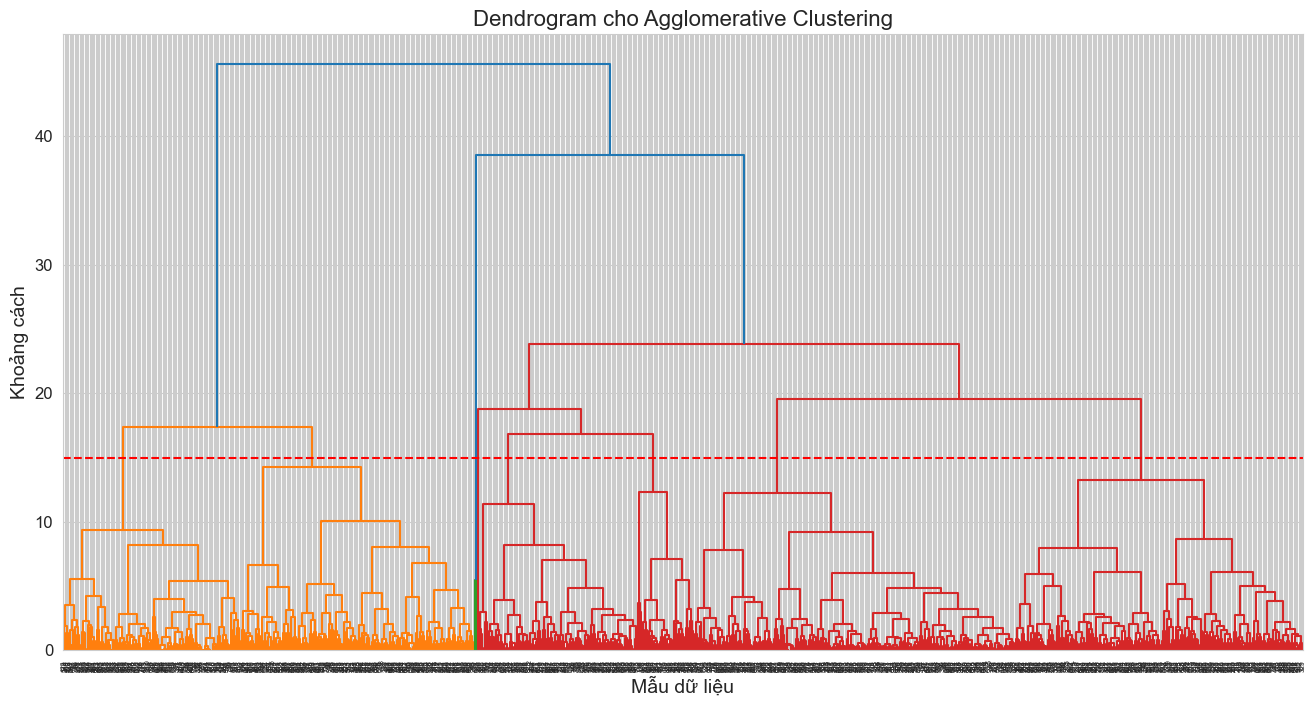

In [52]:
# V·∫Ω dendrogram ƒë·ªÉ x√°c ƒë·ªãnh s·ªë c·ª•m t·ªëi ∆∞u
plt.figure(figsize=(16, 8))
plt.title('Dendrogram cho Agglomerative Clustering', fontsize=16)
plt.xlabel('M·∫´u d·ªØ li·ªáu', fontsize=14)
plt.ylabel('Kho·∫£ng c√°ch', fontsize=14)

# S·ª≠ d·ª•ng m·∫´u nh·ªè n·∫øu d·ªØ li·ªáu qu√° l·ªõn
sample_size = min(1000, len(df_agg))
sample_data = df_agg.sample(sample_size, random_state=42) if len(df_agg) > sample_size else df_agg

# T√≠nh to√°n linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# V·∫Ω dendrogram
dendrogram(linkage_matrix)
plt.axhline(y=15, color='r', linestyle='--')  # ƒê∆∞·ªùng tham chi·∫øu ƒë·ªÉ ch·ªçn s·ªë c·ª•m
plt.show()

n_clusters = 2:
  Silhouette Score: 0.2665
  Davies-Bouldin Score: 1.4043
  Calinski-Harabasz Score: 1754.2411
n_clusters = 3:
  Silhouette Score: 0.2723
  Davies-Bouldin Score: 1.0051
  Calinski-Harabasz Score: 1618.7676
n_clusters = 4:
  Silhouette Score: 0.1456
  Davies-Bouldin Score: 1.4441
  Calinski-Harabasz Score: 1415.9526
n_clusters = 5:
  Silhouette Score: 0.1540
  Davies-Bouldin Score: 1.3627
  Calinski-Harabasz Score: 1287.6890
n_clusters = 6:
  Silhouette Score: 0.1561
  Davies-Bouldin Score: 1.5424
  Calinski-Harabasz Score: 1176.9280
n_clusters = 7:
  Silhouette Score: 0.1432
  Davies-Bouldin Score: 1.6121
  Calinski-Harabasz Score: 1120.0489
n_clusters = 8:
  Silhouette Score: 0.1515
  Davies-Bouldin Score: 1.5445
  Calinski-Harabasz Score: 1048.8867


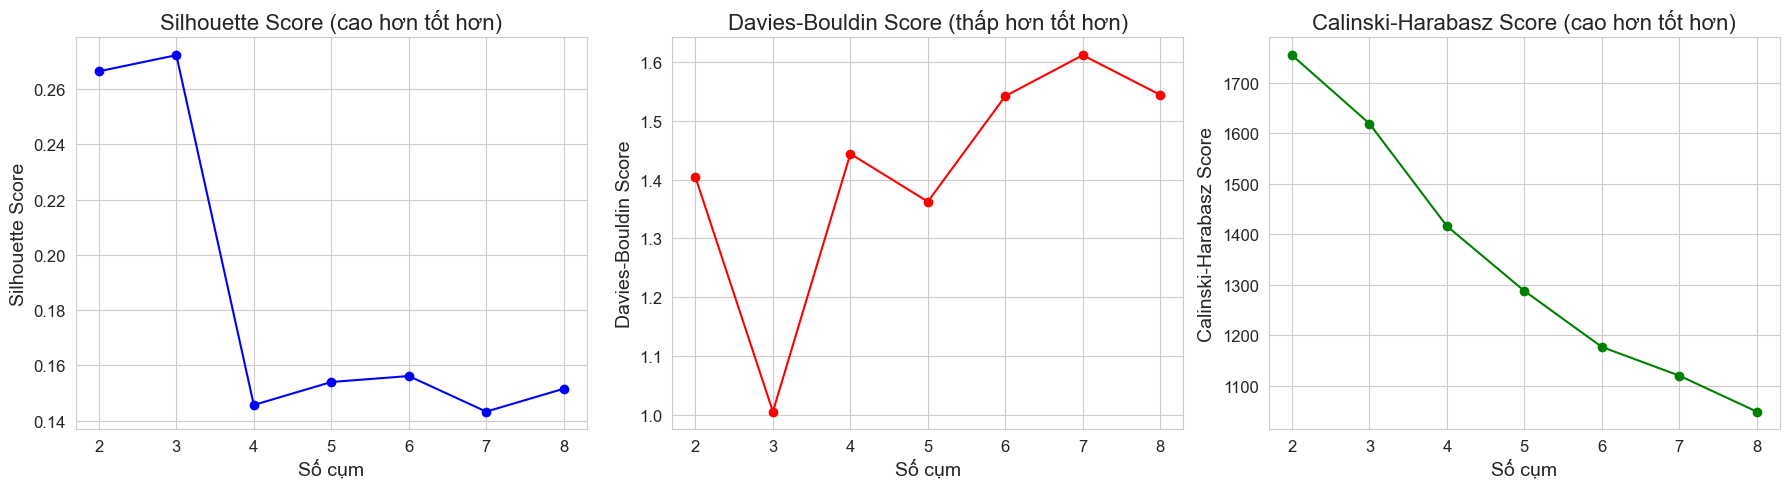

In [54]:
from sklearn.cluster import AgglomerativeClustering

# Th·ª≠ nghi·ªám v·ªõi m·ªôt s·ªë l∆∞·ª£ng c·ª•m kh√°c nhau
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in n_clusters_list:
    # √Åp d·ª•ng Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(df_agg)
    
    # T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√°
    silhouette = silhouette_score(df_agg, cluster_labels)
    davies_bouldin = davies_bouldin_score(df_agg, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(df_agg, cluster_labels)
    
    # L∆∞u k·∫øt qu·∫£
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    print(f"n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.4f}")

# V·∫Ω bi·ªÉu ƒë·ªì k·∫øt qu·∫£
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(n_clusters_list, silhouette_scores, 'o-', color='blue')
ax[0].set_xlabel('S·ªë c·ª•m')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Score (cao h∆°n t·ªët h∆°n)')

ax[1].plot(n_clusters_list, davies_bouldin_scores, 'o-', color='red')
ax[1].set_xlabel('S·ªë c·ª•m')
ax[1].set_ylabel('Davies-Bouldin Score')
ax[1].set_title('Davies-Bouldin Score (th·∫•p h∆°n t·ªët h∆°n)')

ax[2].plot(n_clusters_list, calinski_harabasz_scores, 'o-', color='green')
ax[2].set_xlabel('S·ªë c·ª•m')
ax[2].set_ylabel('Calinski-Harabasz Score')
ax[2].set_title('Calinski-Harabasz Score (cao h∆°n t·ªët h∆°n)')

plt.tight_layout()
plt.show()


S·ªë c·ª•m t·ªëi ∆∞u d·ª±a tr√™n Silhouette Score: 3

=== PH√ÇN T√çCH PH√ÇN PH·ªêI C·ª¶A C√ÅC C·ª§M ===
cluster
0    3801
1    1858
2       6
Name: count, dtype: int64

Ph·∫ßn trƒÉm ph√¢n ph·ªëi:
cluster
0    67.096205
1    32.797882
2     0.105914
Name: count, dtype: float64


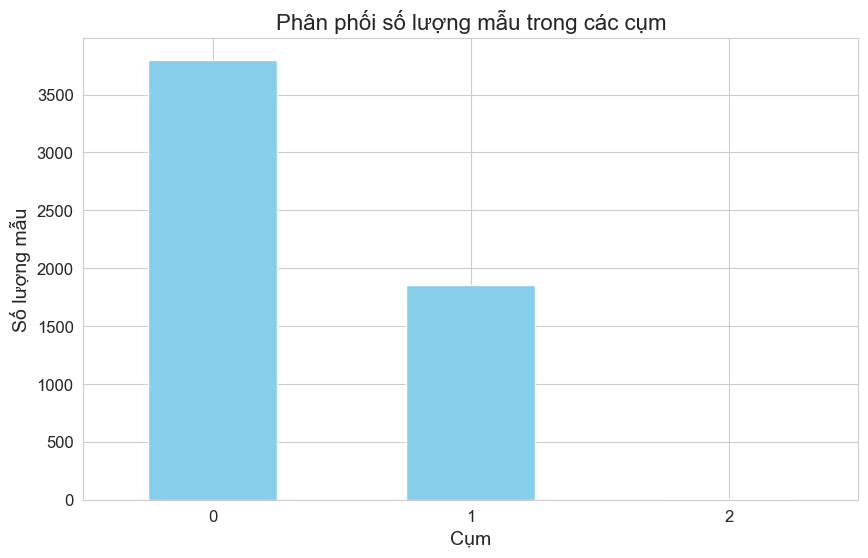

In [55]:
# Ch·ªçn s·ªë c·ª•m t·ªëi ∆∞u d·ª±a tr√™n k·∫øt qu·∫£
optimal_n_clusters = n_clusters_list[silhouette_scores.index(max(silhouette_scores))]
print(f"\nS·ªë c·ª•m t·ªëi ∆∞u d·ª±a tr√™n Silhouette Score: {optimal_n_clusters}")

# √Åp d·ª•ng Agglomerative Clustering v·ªõi s·ªë c·ª•m t·ªëi ∆∞u
final_model = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
df['cluster'] = final_model.fit_predict(df_agg)

# Ph√¢n t√≠ch k·∫øt qu·∫£ ph√¢n c·ª•m
print("\n=== PH√ÇN T√çCH PH√ÇN PH·ªêI C·ª¶A C√ÅC C·ª§M ===")
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)
print("\nPh·∫ßn trƒÉm ph√¢n ph·ªëi:")
print(100 * cluster_counts / len(df))

# Tr·ª±c quan h√≥a ph√¢n ph·ªëi c·ª•m
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Ph√¢n ph·ªëi s·ªë l∆∞·ª£ng m·∫´u trong c√°c c·ª•m')
plt.xlabel('C·ª•m')
plt.ylabel('S·ªë l∆∞·ª£ng m·∫´u')
plt.xticks(rotation=0)
plt.show()



# So s√°nh c√°c metrics


Agglomerative Clustering:
Silhouette Score: 0.2723
Davies-Bouldin Index: 1.0051
Calinski-Harabasz Index: 1618.7676


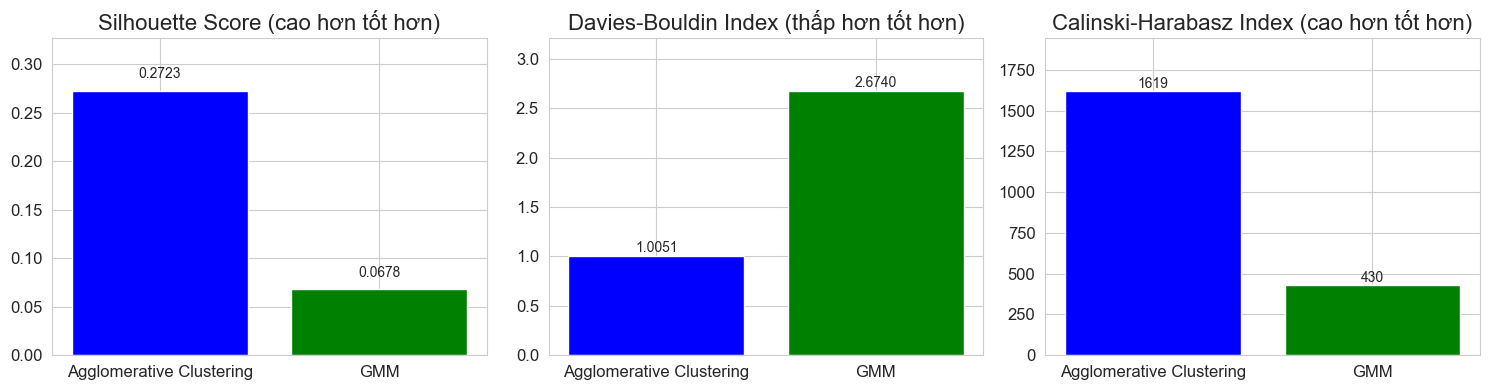


=== B·∫¢NG K·∫æT QU·∫¢ ƒê√ÅNH GI√Å C√ÅC M√î H√åNH ===
                      Model  Silhouette Score  Davies-Bouldin Index  \
0  Agglomerative Clustering          0.272319              1.005079   
1                       GMM          0.067766              2.673992   

   Calinski-Harabasz Index  
0              1618.767614  
1               429.717912  


In [56]:
metrics_results = []


# T√≠nh metrics cho Agglomerative Clustering
silhouette = silhouette_score(df_agg, df['cluster'])
davies_bouldin = davies_bouldin_score(df_agg, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_agg, df['cluster'])

print(f"\nAgglomerative Clustering:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

metrics_results.append(['Agglomerative Clustering', silhouette, davies_bouldin, calinski_harabasz])

gmm_silhouette = silhouette_score(df_gmm, gmm_clusters)
gmm_davies_bouldin = davies_bouldin_score(df_gmm, gmm_clusters)
gmm_calinski_harabasz = calinski_harabasz_score(df_gmm, gmm_clusters)

# C·∫≠p nh·∫≠t b·∫£ng metrics ƒë·ªÉ bao g·ªìm GMM
metrics_results.append(['GMM', gmm_silhouette, gmm_davies_bouldin, gmm_calinski_harabasz])

# T·∫°o DataFrame ƒë·ªÉ hi·ªÉn th·ªã k·∫øt qu·∫£
metrics_df = pd.DataFrame(metrics_results, 
                         columns=['Model', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh Silhouette Score
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
bars = plt.bar(metrics_df['Model'], metrics_df['Silhouette Score'], color=['blue', 'green'])
plt.title('Silhouette Score (cao h∆°n t·ªët h∆°n)')
plt.ylim(0, max(metrics_df['Silhouette Score'][~np.isnan(metrics_df['Silhouette Score'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh Davies-Bouldin Index
plt.subplot(1, 3, 2)
bars = plt.bar(metrics_df['Model'], metrics_df['Davies-Bouldin Index'], color=['blue', 'green'])
plt.title('Davies-Bouldin Index (th·∫•p h∆°n t·ªët h∆°n)')
plt.ylim(0, max(metrics_df['Davies-Bouldin Index'][~np.isnan(metrics_df['Davies-Bouldin Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh Calinski-Harabasz Index
plt.subplot(1, 3, 3)
bars = plt.bar(metrics_df['Model'], metrics_df['Calinski-Harabasz Index'], color=['blue', 'green'])
plt.title('Calinski-Harabasz Index (cao h∆°n t·ªët h∆°n)')
plt.ylim(0, max(metrics_df['Calinski-Harabasz Index'][~np.isnan(metrics_df['Calinski-Harabasz Index'])]) * 1.2)
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Hi·ªÉn th·ªã b·∫£ng k·∫øt qu·∫£ ƒë√°nh gi√°
print("\n=== B·∫¢NG K·∫æT QU·∫¢ ƒê√ÅNH GI√Å C√ÅC M√î H√åNH ===")
print(metrics_df)